In [24]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import os
%matplotlib inline

In [3]:
metadata = pd.read_csv('metadata.csv')
train_labels = pd.read_csv('train_labels.csv')
all_ids = list(metadata.sample_id)
metadata.head()

,sample_id,split,derivatized,features_path,features_md5_hash
0,S0000,train,NaN,train_features/S0000.csv,52ec6d6f8372500ab4e069b5fbdae6f9
1,S0001,train,NaN,train_features/S0001.csv,348f90baed8a8189bf0d4c7b9ed9f965
2,S0002,train,1.0,train_features/S0002.csv,4686ad9bc3716966f63b6ff83d1d8324
3,S0003,train,NaN,train_features/S0003.csv,de6b53605c5887967dc3661a3a711c2b
4,S0004,train,NaN,train_features/S0004.csv,fbfd90092d10d15a5d6919327ddde2ab


In [4]:

def metadata_parser(metadata):
    train_dict = {}
    val_dict = {}
    for row in metadata.iterrows():
        if row[1].split == 'train':
            train_dict[row[1].sample_id] = row[1].features_path
        else:
            val_dict[row[1].sample_id] = row[1].features_path
    return train_dict, val_dict

def train_label_parser(train_labels):
    train_labels_dict = {}
    for row in train_labels.iterrows():
        row_list = list(row[1])
        train_labels_dict[row_list[0]] = row_list[1:]
    columns = list(train_labels.columns)
    return train_labels_dict, columns[1:]

def get_ids_per_class():
    ids_per_class = {}
    for class_name in labels:
        index = labels.index(class_name)
        ids = []
        for key, value in train_labels_dict.items():
            if value[index] == 1:
                ids.append(key)
        ids_per_class[class_name] = ids
    return ids_per_class

def find_absolute_maximum_mass():
    print("Finding absolute maximum mass")
    pb = tqdm(total=len(all_ids))
    absolute_max = 0
    for key, value in all_paths.items():
        pb.update(1)
        data = pd.read_csv(value)
        data.sort_values('mass')
        max_mass = data['mass'].max()
        absolute_max = max(absolute_max, max_mass)
    return absolute_max

def data_parser(id):
    path = all_paths[id]
    data = pd.read_csv(path)
    data = data.sort_values('mass')
    labels = list(data.columns)
    data_json = {
        'time': np.array(data.time),
        'mass': np.array(data.mass),
        'intensity': np.array(data.intensity),
    }
    return data_json

def descretize(data, mass_range, interval):
    mass = data['mass'].copy()
    intensity = data['intensity'].copy()
    num_elements = int(mass_range / interval) + 1
    intensity_desc = np.zeros(num_elements)
    for i in range(num_elements):
        mass_start = i * interval
        mass_end = (i + 1) * interval
        mask = (mass >= mass_start) & (mass < mass_end)
        if np.any(mask):
            intensity_desc[i] = np.max(intensity[mask])
    return intensity_desc


def extract_features(data, num_features, id):
    mz_array = data['mass']
    intensity_array = data['intensity']
    target_label_array = np.array(train_labels_dict[id])
    features = np.vstack((mz_array, intensity_array)).T
    selector = SelectKBest(score_func=f_classif, k=num_features)
    selected_features = selector.fit_transform(features, target_label_array)
    return selected_features

def intensity_vs_mass_plotter(sample_id, discretized=False, mass_range=650, interval=0.5):
    data = data_parser(sample_id)
    if discretized:
        data['intensity'] = descretize(data, mass_range, interval)
        data['mass'] = np.array([i*interval for i in range(len(data['intensity']))])
    fig, axs = plt.subplots(figsize=(20, 10))
    axs.set_xlim(0, 650)
    axs.plot(data['mass'], data['intensity'])

def abosulte_average_deviation():
    deviations = 0
    count = 0
    for sample_id in tqdm(all_ids):
        data = data_parser(sample_id)
        mass = data['mass']
        for i in range(len(mass) - 1):
            deviations += np.abs(mass[i+1] - mass[i])
            count += 1
    return deviations, count

def descritize_dataset(dataset_paths, max_mass, step, file_name):
    with open(file_name, 'w+') as f:
        columns = ['sample_id']
        num_elements = int(max_mass / step) + 1
        for i in range(num_elements):
            columns.append(f'I{i}')
        f.write(','.join(columns) + '\n')
        for key, value in tqdm(dataset_paths.items()):
            data = data_parser(key)
            intensity_desc = descretize(data, max_mass, step)
            max_intensity = np.max(intensity_desc)
            values = key+','+','.join([str(i/max_intensity) for i in intensity_desc]) + '\n'
            f.write(values)

def perform_pca(train_path, val_path, num_features):
    desired_num_features = num_features
    pca = PCA(n_components=desired_num_features)
    train_data = pd.read_csv(train_path)
    val_data = pd.read_csv(val_path)
    train_features = train_data.iloc[:, 1:-1].values
    val_features = val_data.iloc[:, 1:-1].values

    pca.fit(train_features)

    reduced_features_train = pd.DataFrame(pca.transform(train_features))
    reduced_features_val = pd.DataFrame(pca.transform(val_features))
    reduced_features_train.insert(0, 'sample_id', train_data['sample_id'])
    reduced_features_val.insert(0, 'sample_id', val_data['sample_id'])
    
    reduced_features_train.to_csv(f'train_pca{num_features}.csv', index=False)
    reduced_features_val.to_csv(f'val_pca{num_features}.csv', index=False)

train_path, val_path = metadata_parser(metadata)
train_labels_dict, labels = train_label_parser(train_labels)
all_paths = {**train_path, **val_path}
ids_per_class = get_ids_per_class()
# absolute_maximum_mass = find_absolute_maximum_mass()   Already found
# absolute_average_deviation, total_count = abosulte_average_deviation() Already Done
absolute_maximum_mass = 649.96228 
absolute_mean_diff = 544345.6024272853/591544015
print("Absolute maximum mass: ", absolute_maximum_mass)
print("Absolute mean difference: ", absolute_mean_diff)


# print("Descretizing train dataset")
# descritize_dataset(train_path, 650, 0.1, "train_descrete.csv")
# print("Descretizing test dataset")
# descritize_dataset(val_path, 650, 0.1, "val_descrete.csv")

# Reducing number of features using PCA
# perform_pca('train_descrete.csv', 'val_descrete.csv', 800)

Absolute maximum mass:  649.96228
Absolute mean difference:  0.0009202114950436702


In [10]:
def return_descrete_data(path, labels_dict=None):
    data = pd.read_csv(path)
    sample_ids = list(data.sample_id)
    data.drop('sample_id', axis=1, inplace=True)
    X = np.array(data)
    y = []
    if labels_dict is not None:
        for sample_id in sample_ids:
            y.append(labels_dict[sample_id])
    return X, np.array(y)

X, y = return_descrete_data('train_descrete.csv', train_labels_dict)
input_shape = X.shape[1]
X.shape, y.shape

((809, 1301), (809, 9))

In [27]:
def evaluate_model(model, X_val, y_val, history=None):
    # Plot the training and validation loss
    if history is not None:
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(train_loss) + 1)

        plt.figure(figsize=(10, 7))
        plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
        plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        epochs = range(1, len(train_acc) + 1)

        plt.figure(figsize=(10, 7))
        plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
    y_pred = model.predict(X_val, verbose=False).round()
    class_rep = classification_report(y_val, y_pred)
    confusion_matrix = multilabel_confusion_matrix(y_val, y_pred)
    print(class_rep)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    eps = 1e-7
    per_label_log_loss = -(y_val * np.log(y_pred+eps) + (1 - y_val) * np.log(1 - y_pred+eps))
    aggregated_log_loss = np.mean(per_label_log_loss)
    
    # Random Loss
    prob = y_val.sum()/(y_val.shape[0]*y_val.shape[1])
    y_random = np.random.binomial(1, prob, y_val.shape)
    per_label_log_loss_rand = -(y_val * np.log(y_random+eps) + (1 - y_val) * np.log(1 - y_random+eps))
    aggregated_log_loss_rand = np.mean(per_label_log_loss_rand)

    axes = axes.flatten()
    for i, matrix in enumerate(confusion_matrix):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(f'{labels[i]} Confusion Matrix')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()
    
    print("Log Loss: ", aggregated_log_loss)
    print("Log Loss Random: ", aggregated_log_loss_rand)
    print("Accuracy: ", (y_pred == y_val).sum()/(y_val.shape[0]*y_val.shape[1])*100, "%")
    print("--------------------------------------------")
    return aggregated_log_loss


class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model):
        super(CustomCallback, self).__init__()
        self.model = model
        self.min_score = 100

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(X_val, verbose=False).round()
        eps = 1e-7
        per_label_log_loss = -(y_val * np.log(y_pred+eps) + (1 - y_val) * np.log(1 - y_pred+eps))
        aggregated_log_loss = np.mean(per_label_log_loss)
        if aggregated_log_loss < self.min_score:
            if os.path.exists('best_model.h5'):
                os.remove('best_model.h5')
            self.model.save('best_model.h5')
            self.min_score = aggregated_log_loss

In [28]:
def multilabel_aggregated_log_loss(y_true, y_pred):
    epsilon = 1e-7
    y_true = tf.cast(y_true, tf.float32)
    per_label_log_loss = -(y_true * tf.math.log(y_pred+epsilon) + (1 - y_true) * tf.math.log(1 - y_pred+epsilon))
    aggregated_log_loss = tf.reduce_mean(per_label_log_loss)
    return aggregated_log_loss

def train_tf_model(X_train, y_train, X_val, y_val, input_shape):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='auto', min_delta=0.001)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(640, activation='relu', input_shape=(input_shape,)))
    model.add(tf.keras.layers.Dense(320, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(160, activation='relu'))
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(80, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(40, activation='relu'))
    model.add(tf.keras.layers.Dense(20, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(9, activation='sigmoid'))

    model.compile(optimizer='adam', loss=multilabel_aggregated_log_loss, metrics=['accuracy'])
    checkpoint = CustomCallback(model)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, batch_size=32, verbose=True, callbacks=[checkpoint])
    model_tf = tf.keras.models.load_model('best_model.h5', custom_objects={'multilabel_aggregated_log_loss': multilabel_aggregated_log_loss})
    return model, history

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=100)
X_val, X_eval, y_val, y_eval = train_test_split(X_val, y_val, test_size=0.5, random_state=120)
model_tf, history_tf = train_tf_model(X_train, y_train, X_val, y_val, X_train.shape[1])

Epoch 1/400
22/22 [==============================] - 2s 32ms/step - loss: 0.5414 - accuracy: 0.1194 - val_loss: 0.3419 - val_accuracy: 0.3115
Epoch 2/400
22/22 [==============================] - 0s 21ms/step - loss: 0.3791 - accuracy: 0.2256 - val_loss: 0.2951 - val_accuracy: 0.3115
Epoch 3/400
22/22 [==============================] - 1s 26ms/step - loss: 0.3191 - accuracy: 0.2489 - val_loss: 0.2590 - val_accuracy: 0.3115
Epoch 4/400
22/22 [==============================] - 1s 28ms/step - loss: 0.2707 - accuracy: 0.3057 - val_loss: 0.2200 - val_accuracy: 0.4098
Epoch 5/400
22/22 [==============================] - 0s 21ms/step - loss: 0.2368 - accuracy: 0.3901 - val_loss: 0.2202 - val_accuracy: 0.4098
Epoch 6/400
22/22 [==============================] - 1s 25ms/step - loss: 0.2197 - accuracy: 0.3843 - val_loss: 0.1857 - val_accuracy: 0.4426
Epoch 7/400
22/22 [==============================] - 0s 21ms/step - loss: 0.2009 - accuracy: 0.3828 - val_loss: 0.1788 - val_accuracy: 0.4590
Epoch 

c:\Users\Shashank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Shashank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       1.00      0.95      0.98        22
           2       0.67      0.86      0.75         7
           3       0.83      0.71      0.77         7
           4       0.67      0.67      0.67         3
           5       1.00      0.50      0.67         4
           6       1.00      0.50      0.67         4
           7       1.00      1.00      1.00         2
           8       0.89      0.89      0.89         9

   micro avg       0.88      0.83      0.85        64
   macro avg       0.88      0.77      0.80        64
weighted avg       0.90      0.83      0.85        64
 samples avg       0.57      0.56      0.56        64



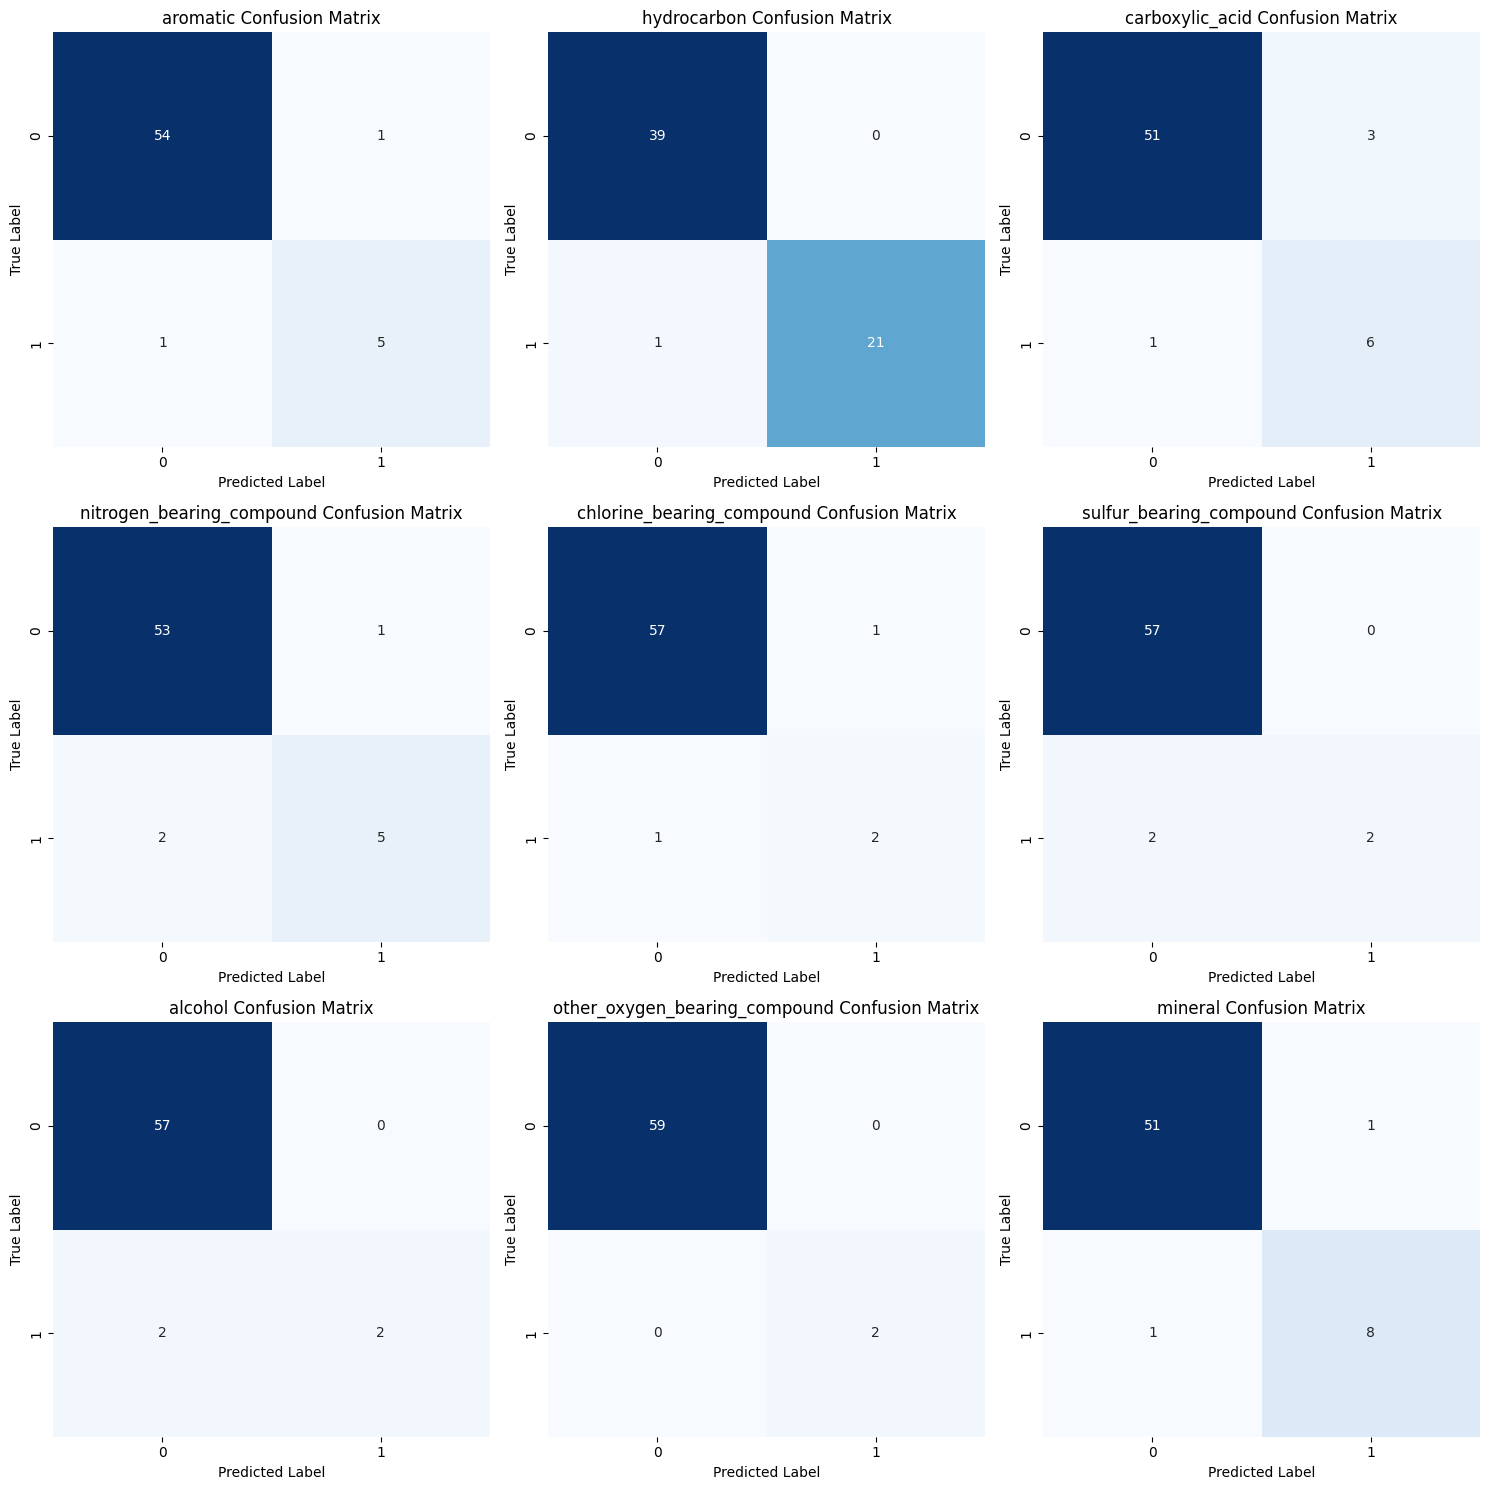

Log Loss:  0.5284620288942817
Log Loss Random:  3.082695808653235
Accuracy:  96.72131147540983 %
--------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       1.00      0.95      0.97        19
           2       0.82      0.90      0.86        10
           3       0.71      0.62      0.67         8
           4       1.00      1.00      1.00         1
           5       0.50      0.50      0.50         2
           6       0.33      0.50      0.40         2
           7       1.00      0.50      0.67         2
           8       0.71      0.62      0.67         8

   micro avg       0.84      0.79      0.81        58
   macro avg       0.79      0.71      0.74        58
weighted avg       0.85      0.79      0.82        58
 samples avg       0.49      0.49      0.49        58



c:\Users\Shashank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Shashank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


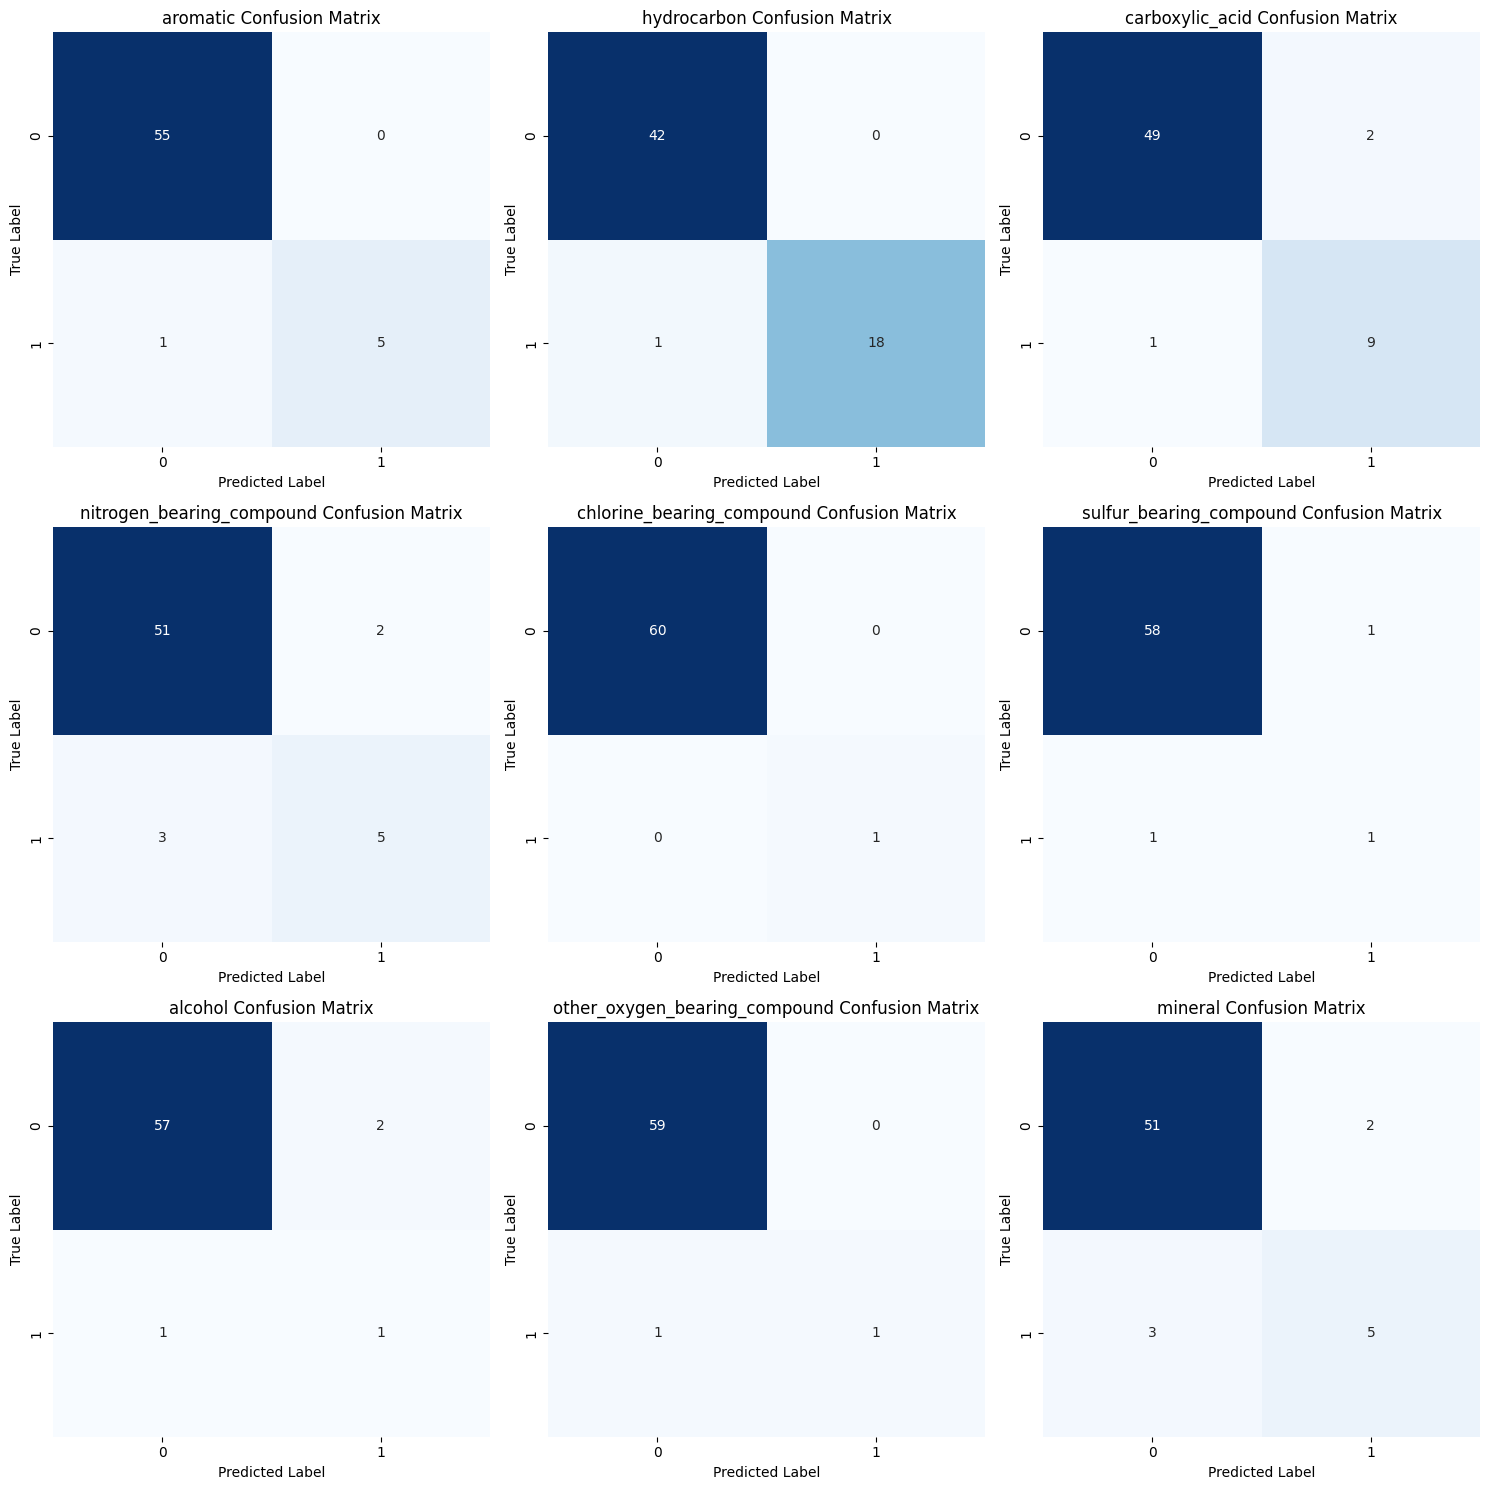

Log Loss:  0.6165390535782079
Log Loss Random:  2.8478237394225125
Accuracy:  96.17486338797814 %
--------------------------------------------


0.6165390535782079

In [31]:
evaluate_model(model_tf, X_val, y_val)
evaluate_model(model_tf, X_eval, y_eval)

In [34]:
val_data = pd.read_csv('val_descrete.csv')
val_data_samples = val_data.sample_id
val_data_values = val_data.drop(['sample_id'], axis=1).values
predictions = model_tf.predict(val_data_values).round()
submission = pd.DataFrame(predictions)
submission.insert(0, 'sample_id', val_data_samples)
new_column_names = {i: label for i, label in enumerate(labels)}
submission.rename(columns=new_column_names, inplace=True)
submission.to_csv('mystic_submission.csv', index=False)

10/10 [==============================] - 0s 4ms/step
